In [1]:
import numpy as np
import operator
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import math

In [2]:
class treeNode():
    def __init__(self, feat, val, right, left):
        self.featureToSplitOn = feat
        self.valueOfSplit = val
        self.rightBranch = right
        self.leftBranch = left        

In [3]:
def isTree(obj):
    return (type(obj)==treeNode)

In [4]:
def printTree(tN, d=0):
    for i in range(d):
        print('  |',end='')
    if(isTree(tN)):
        print('feature ' , tN.featureToSplitOn ,' at ' , tN.valueOfSplit)
        printTree(tN.rightBranch, d+1)
        printTree(tN.leftBranch, d+1)
    else :
        if(type(tN) == np.matrixlib.defmatrix.matrix ):
            print(tN.T.A.ravel())
        else:
            print(tN)

In [5]:
def bestSplit(tN):
    bestFeatures=[]
    bestValues=[]
    if(isTree(tN)):
        bestFeatures.append(tN.featureToSplitOn) 
        bestValues.append(tN.valueOfSplit) 
        #if(tN.rightBranch != None)
        bf,bv = bestSplit(tN.rightBranch)
        bestFeatures.extend(bf)
        bestValues.extend(bv)
        bf,bv = bestSplit(tN.leftBranch)
        bestFeatures.extend(bf)
        bestValues.extend(bv)
        #return bestFeatures, bestValues
    return bestFeatures, bestValues

In [6]:
def loadDataSet(fileName):      #general function to parse tab -delimited floats
    dataMat = []                #assume last column is target value
    fr = open(fileName)
    for line in fr.readlines():
        curLine = line.strip().split('\t')
        fltLine = list(map(float,curLine)) #map all elements to float()
        dataMat.append(fltLine)
    return np.mat(dataMat)

In [7]:
myMat = loadDataSet('ex00.txt')

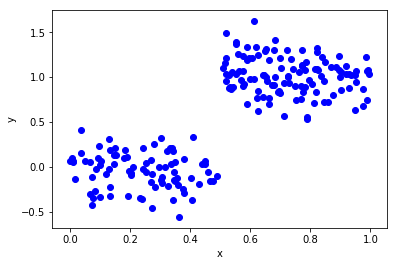

In [8]:
plt.scatter(myMat[:,0].A,myMat[:,1].A,color="blue") #np.matrix.A--->matrix转化为array
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [9]:
def binSplitDataSet(dataSet, feature, value):
    mat0 = dataSet[np.nonzero(dataSet[:,feature] > value)[0],:] #[0]
    mat1 = dataSet[np.nonzero(dataSet[:,feature] <= value)[0],:] #[0]
    return mat0, mat1

In [10]:
testMat = np.mat(np.eye(4))
binSplitDataSet(testMat, 1, 0.5)

(matrix([[0., 1., 0., 0.]]), matrix([[1., 0., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]))

In [11]:
def regLeaf(dataSet):#returns the value used for each leaf
    return np.mean(dataSet[:,-1])

In [12]:
def regErr(dataSet):
    return np.var(dataSet[:,-1]) * np.shape(dataSet)[0]

In [13]:
def chooseBestSplit(dataSet, leafType=regLeaf, errType=regErr, ops=(1,4)):
    tolS = ops[0]; tolN = ops[1]
    #if all the target variables are the same value: quit and return value
    if len(set(dataSet[:,-1].T.tolist()[0])) == 1: #exit cond 1
        return None, leafType(dataSet)
    m,n = np.shape(dataSet)
    #the choice of the best feature is driven by Reduction in RSS error from mean
    S = errType(dataSet)
    bestS = np.inf; bestIndex = 0; bestValue = 0
    # 最后一个元素 是 特征值
    for featIndex in range(n-1):
        for splitVal in set(dataSet[:,featIndex].A.ravel()):
            mat0, mat1 = binSplitDataSet(dataSet, featIndex, splitVal)
            if (np.shape(mat0)[0] < tolN) or (np.shape(mat1)[0] < tolN): continue
            # 计算两边的总方差    
            newS = errType(mat0) + errType(mat1)
            if newS < bestS: 
                bestIndex = featIndex
                bestValue = splitVal
                bestS = newS
    #if the decrease (S-bestS) is less than a threshold don't do the split
    if (S - bestS) < tolS: 
        return None, leafType(dataSet) #exit cond 2
    mat0, mat1 = binSplitDataSet(dataSet, bestIndex, bestValue)
    if (np.shape(mat0)[0] < tolN) or (np.shape(mat1)[0] < tolN):  #exit cond 3
        return None, leafType(dataSet)
    return bestIndex,bestValue#returns the best feature to split on
                              #and the value used for that split

In [14]:
#assume dataSet is NumPy Mat so we can array filtering
def createTree(dataSet, leafType=regLeaf, errType=regErr, ops=(1,4)):
    feat, val = chooseBestSplit(dataSet, leafType, errType, ops)#choose the best split
    if feat == None: return val #if the splitting hit a stop condition return val
    #feat, val, right, left
    lSet, rSet = binSplitDataSet(dataSet, feat, val)
    retTree = treeNode(feat, val, \
                       createTree(rSet, leafType, errType, ops), \
                       createTree(lSet, leafType, errType, ops) )
    return retTree  

In [15]:
myTree = createTree(myMat, regLeaf, regErr, ops=(1,4))

In [16]:
printTree(myTree, 0)

feature  0  at  0.48813
  |-0.04465028571428572
  |1.0180967672413792


In [17]:
bf, bv = bestSplit(myTree)

In [18]:
def plotTree(myMat, bv, xl = 0, yl = 1):
    plt.scatter(myMat[:,xl].A,myMat[:,yl].A,color="blue")
    y = myMat[:,-1].A
    y_min = np.min(y) - 0.1
    y_max = np.max(y) + 0.1
    y_val = np.arange(y_min,y_max,0.01)
    for i in range(len(bv)):
        plt.plot([bv[i]]* y_val.shape[0], y_val,color="black") #画出那条分界线
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

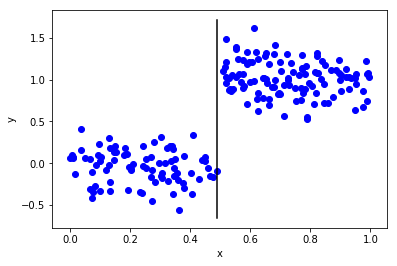

In [19]:
plotTree(myMat, bv)

In [20]:
myData= loadDataSet('ex0.txt')
myTree2 = createTree(myData)
bf, bv = bestSplit(myTree2)

In [21]:
printTree(myTree2)

feature  1  at  0.39435
  |feature  1  at  0.197834
  |  |-0.023838155555555553
  |  |1.0289583666666666
  |feature  1  at  0.582002
  |  |1.980035071428571
  |  |feature  1  at  0.797583
  |  |  |2.9836209534883724
  |  |  |3.9871632


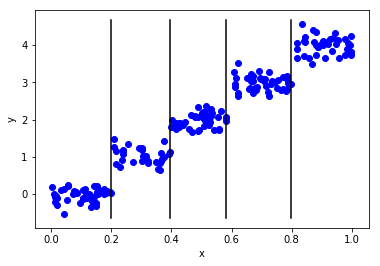

In [22]:
plotTree(myData, bv,1,2)

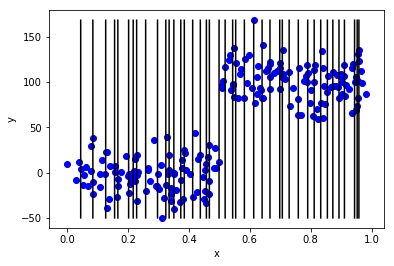

In [23]:
myDat2= loadDataSet('ex2.txt')
myTree2 = createTree(myDat2, ops=(1,4))
bf, bv = bestSplit(myTree2)
plotTree(myDat2, bv)

In [24]:
def getMean(tree):
    if isTree(tree):
        tr = getMean(tree.rightBranch)
        tl = getMean(tree.leftBranch)
        return (tr + tl)/2.0
    return tree;

In [25]:
def prune(tree, testData):
    if np.shape(testData)[0] == 0:
        return getMean(tree) #if we have no test data collapse the tree
    if (isTree(tree.rightBranch) or isTree(tree.leftBranch)):#if the branches are not trees try to prune them
        lSet, rSet = binSplitDataSet(testData, tree.featureToSplitOn, tree.valueOfSplit)
    if isTree(tree.leftBranch): tree.leftBranch = prune(tree.leftBranch, lSet)
    if isTree(tree.rightBranch): tree.rightBranch =  prune(tree.rightBranch, rSet)
    #if they are now both leafs, see if we can merge them
    if not isTree(tree.leftBranch) and not isTree(tree.rightBranch):
        lSet, rSet = binSplitDataSet(testData,tree.featureToSplitOn, tree.valueOfSplit)
        errorNoMerge = sum(np.power(lSet[:,-1] - tree.leftBranch, 2)) + \
            sum(np.power(rSet[:,-1] - tree.rightBranch, 2))
        treeMean = (tree.leftBranch + tree.rightBranch ) / 2.0
        errorMerge = sum(np.power(testData[:,-1] - treeMean,2))
        if errorMerge < errorNoMerge: 
            print ("merging")
            return treeMean
        else:
            #print (errorMerge, errorNoMerge)
            return tree
    else: return tree

merging
merging
merging
merging
merging
merging
merging
merging
merging


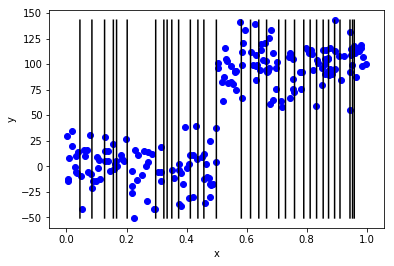

In [26]:
myMat2= loadDataSet('ex2test.txt')
#myTree2 = createTree(myMat2, ops=(0,1))
myTree2 = prune(myTree2,myMat2)
bf, bv = bestSplit(myTree2)
plotTree(myMat2, bv)

In [27]:
def linearSolve(dataSet):   #helper function used in two places
    m,n = np.shape(dataSet)
    X = np.mat(np.ones((m,n))); 
    Y = np.mat(np.ones((m,1)))#create a copy of data with 1 in 0th postion
    X[:,1:n] = dataSet[:,0:n-1];
    Y = dataSet[:,-1]#and strip out Y
    xTx = X.T*X
    if np.linalg.det(xTx) == 0.0:
        raise NameError('This matrix is singular, cannot do inverse,\n\
        try increasing the second value of ops')
    ws = xTx.I * (X.T * Y)
    return ws,X,Y

In [28]:
def modelLeaf(dataSet):#create linear model and return coeficients
    ws,X,Y = linearSolve(dataSet)
    return ws

In [29]:
def modelErr(dataSet):
    ws,X,Y = linearSolve(dataSet)
    yHat = X * ws
    return sum(np.power(Y - yHat,2))

In [30]:
myMat2 =loadDataSet('exp2.txt')
myTree2 = createTree(myMat2, modelLeaf, modelErr,(1,10))
printTree(myTree2)

feature  0  at  0.285477
  |[3.46877936 1.18521743]
  |[1.69855694e-03 1.19647739e+01]


In [31]:
#回归树，直接返回叶子节点的值：小数据集合的均值
def regTreeEval(modle, inData):
    return float(modle)

In [32]:
#模型树，返回线性方程的值
def modelTreeEval(modle, inData):
    n = np.shape(inData)[1]
    X = np.mat(np.ones((1,n+1))) #x0=1
    X[:,1:n+1] = inData
    return float(X*modle)

In [33]:
#树的递归预测
def treeForeCast(tree, inData, modelEval=regTreeEval):
    if not isTree(tree): #如果不是树，叶子节点，则返回预测值
        return modelEval(tree, inData)
    if inData.A.ravel()[tree.featureToSplitOn] > tree.valueOfSplit : #大于特征值，则是左子树
        if isTree(tree.leftBranch): #如果是树，继续递归
            return treeForeCast(tree.leftBranch, inData, modelEval) #递归
        else: #如果是叶子节点，直接返回预测值
            return modelEval(tree.leftBranch, inData)
    else: #小于等于则是右子树
        if isTree(tree.rightBranch): 
            return treeForeCast(tree.rightBranch, inData, modelEval)
        else: 
            return modelEval(tree.rightBranch, inData)

In [34]:
#利用生成的树，进行预测
def createForeCast(tree, testData, modelEval=regTreeEval):
    m=len(testData)
    yHat = np.mat(np.zeros((m,1)))
    for i in range(m):
        yHat[i,0] = treeForeCast(tree, np.mat(testData[i]), modelEval) #递归预测
    return yHat


In [35]:
yhat = createForeCast(myTree2,myMat2[:,0:-1],modelEval=modelTreeEval)

In [36]:
# 查看模型数效果
def plotTreeCast(myMat2, yhat):
    srtIndex = myMat2.A[:,0].argsort(0)#排个序
    plt.scatter(myMat2.A[:,0],myMat2.A[:,1],color="blue",marker=".")
    plt.plot(myMat2[:,0].A[srtIndex],yhat.A[srtIndex],color="red",linestyle = "-")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

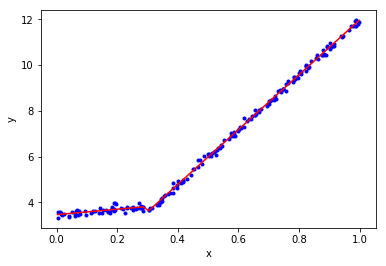

In [37]:
plotTreeCast(myMat2, yhat)

In [38]:
trainMat = loadDataSet('bikeSpeedVsIq_train.txt')
testMat = loadDataSet('bikeSpeedVsIq_test.txt')
myTree = createTree(trainMat, ops=(1,20))
yHat = createForeCast(myTree,testMat[:,0])
np.corrcoef(yHat, testMat[:,0], rowvar = 0)[0,1]

0.9791911678275069

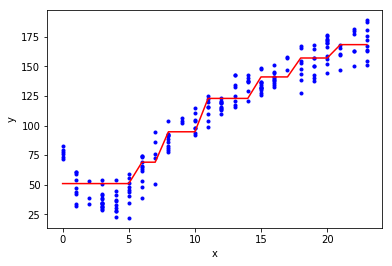

In [39]:
plotTreeCast(testMat, yHat)

In [40]:
ws,X,Y = linearSolve(trainMat)

In [41]:
for i in range(np.shape(testMat)[0]):
    yHat[i] = testMat[i,0] * ws[1,0] + ws[0,0]
np.corrcoef(yHat, testMat[:,1], rowvar = 0)[0,1]

0.9434684235674763

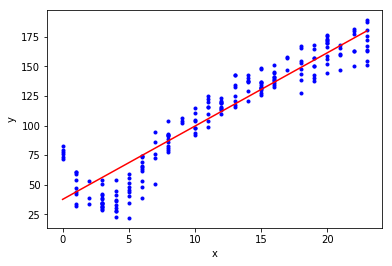

In [42]:
plotTreeCast(testMat, yHat)